In [1]:
%load_ext autoreload
%autoreload 2

In [132]:
import pandas as pd
import numpy as np
import swifter
from llama_cpp import Llama
from langdetect import detect
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from tqdm import tqdm
from sklearn.metrics import (
    accuracy_score,
    precision_score,
    recall_score,
    f1_score,
    confusion_matrix,
    classification_report,
)
from concurrent.futures import ThreadPoolExecutor

In [3]:
tqdm.pandas()

## Prepare dataset 

Prepare the dataset for use, explaining your selection criteria for the subset you choose

In [4]:
splits = {'train': 'train.jsonl', 'test': 'test.jsonl'}
df = pd.read_json("hf://datasets/ajaykarthick/imdb-movie-reviews/" + splits["train"], lines=True)

In [5]:
df.head()

,review,label
0,"Ms Aparna Sen, the maker of Mr & Mrs Iyer, dir...",0
1,"I have seen this film only once, on TV, and it...",0
2,I was only fourteen when I first saw the Alien...,1
3,This marvelous short will hit home with everyo...,0
4,If you are 10 years old and never seen a movie...,1


In [ ]:
# Should check that all these reviews are in English so will use the `langdetect` library to do that
# N.B. this is quite slow(about 2 mins on my machine)
# DO NOT RERUN
# df["language"] = df["review"].apply(detect)

In [6]:
# Let's also add a column for the length of the review
df["review_length"] = df["review"].apply(lambda x: len(x))

In [7]:
df.head()

,review,label,review_length
0,"Ms Aparna Sen, the maker of Mr & Mrs Iyer, dir...",0,2408
1,"I have seen this film only once, on TV, and it...",0,662
2,I was only fourteen when I first saw the Alien...,1,1481
3,This marvelous short will hit home with everyo...,0,830
4,If you are 10 years old and never seen a movie...,1,238


In [8]:
df.describe()

,label,review_length
count,40000.000000,40000.000000
mean,0.500000,1312.303950
std,0.500006,993.920001
min,0.000000,41.000000
25%,0.000000,699.000000
50%,0.500000,970.000000
75%,1.000000,1598.000000
max,1.000000,13704.000000


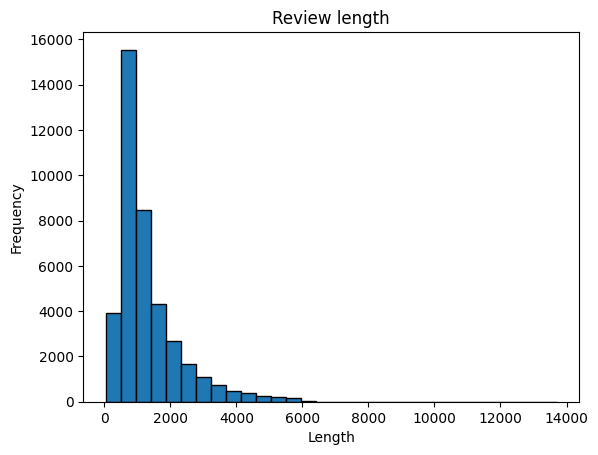

In [16]:
plt.hist(df['review_length'], bins=30, edgecolor='black')

# Add titles and labels
plt.title('Review length')
plt.xlabel('Length')
plt.ylabel('Frequency')

# Show the plot
plt.show()

In [9]:
df['review_length_bin'] = pd.qcut(df['review_length'], q=10)


In [11]:
df.head()

,review,label,review_length,review_length_bin
0,"Ms Aparna Sen, the maker of Mr & Mrs Iyer, dir...",0,2408,"(1829.0, 2583.0]"
1,"I have seen this film only once, on TV, and it...",0,662,"(503.0, 662.0]"
2,I was only fourteen when I first saw the Alien...,1,1481,"(1412.0, 1829.0]"
3,This marvelous short will hit home with everyo...,0,830,"(739.0, 838.0]"
4,If you are 10 years old and never seen a movie...,1,238,"(40.999, 503.0]"


In [ ]:
# Let's check out the language of the reviews quickly
# df['language'].unique()

array(['en', 'id'], dtype=object)

In [ ]:
# Have a look at the examples where the language is not English
# df[df["language"] != "en"]

,review,label,language,review_length,review_length_bin
24998,.....whoops - looks like it's gonna cost you a...,0,id,730,"(662.0, 739.0]"


Looks like all the reviews are in English so most immediate way of subsetting the data is by review_length and the label. Could go deep with something like https://pypi.org/project/py-readability-metrics/ but don't really want to overdo this. 

As for size of subset let's go with 1k for now (not sure what constraints of my machine are yet) and will review later.

In [10]:
X_train, X_test, y_train, y_test = train_test_split(
    df,
    df[["review_length", "label"]],
    stratify=df[["review_length_bin", "label"]],
    test_size=1000,
)

In [7]:
X_train.describe()

,label,review_length
count,39000.000000,39000.000000
mean,0.500000,1312.617923
std,0.500006,994.535534
min,0.000000,41.000000
25%,0.000000,699.000000
50%,0.500000,970.000000
75%,1.000000,1599.000000
max,1.000000,13704.000000


OK looks like that's worked, let's clean up and get onto the next bit

In [12]:
X_test.describe()

,label,review_length
count,1000.00000,1000.00000
mean,0.50000,1306.31600
std,0.50025,970.20587
min,0.00000,98.00000
25%,0.00000,702.00000
50%,0.50000,967.00000
75%,1.00000,1601.25000
max,1.00000,5948.00000


In [11]:
data = X_test[['review', 'label']]

## Implement local inference

- Choose optimal inference parameters (e.g., temperature, top_p, top_k) for each model
- https://llama-cpp-python.readthedocs.io/en/latest/api-reference/#llama_cpp.Llama.create_chat_completion contains avaliable parameters 
- It doesn't look like I can batch up responses so will have to just keep hitting the model: https://github.com/abetlen/llama-cpp-python/issues/1529 
- Unsure how clever I want to be here, will have to see how long it takes to get these responses out 

Stuff to work out / ideas

- [x] How to choose optimal inference params (do I need to do a bit of a hyperparameter tuning?)
- [x] How do I run this stuff in batch mode: YOU CAN'T
- [x] Do I want to try and mess around with context window? Feels like default is set like that for a reason. 
- [x] Need to make a decision RE temperature 
- [x] Make decision on metrics (what is usually used for sentiment analysis?) Probably don't want to overthink this? 

In [12]:
# Small model
llm_small = Llama.from_pretrained(
	repo_id="bartowski/Qwen2.5-0.5B-Instruct-GGUF",
	filename="Qwen2.5-0.5B-Instruct-IQ2_M.gguf",
    n_ctx=0  # uses model default (32768)
)

# Content length from model is `qwen2.context_length = 32768`
# By default Llama defaults to 512 but since the average review length is ~1300 it's better to have this longer
# Clearly better than sticking with the default of 512 and truncating reviews.

llama_load_model_from_file: using device Metal (AMD Radeon Pro 5500M) - 8176 MiB free
llama_model_loader: loaded meta data with 37 key-value pairs and 290 tensors from /Users/anna/.cache/huggingface/hub/models--bartowski--Qwen2.5-0.5B-Instruct-GGUF/snapshots/41ba88dbac95fed2528c92514c131d73eb5a174b/./Qwen2.5-0.5B-Instruct-IQ2_M.gguf (version GGUF V3 (latest))
llama_model_loader: Dumping metadata keys/values. Note: KV overrides do not apply in this output.
llama_model_loader: - kv   0:                       general.architecture str              = qwen2
llama_model_loader: - kv   1:                               general.type str              = model
llama_model_loader: - kv   2:                               general.name str              = Qwen2.5 0.5B Instruct
llama_model_loader: - kv   3:                           general.finetune str              = Instruct
llama_model_loader: - kv   4:                           general.basename str              = Qwen2.5
llama_model_loader: - kv   5:

In [13]:
# Big model
llm_big = Llama.from_pretrained(
	repo_id="bartowski/Qwen2.5-1.5B-Instruct-GGUF",
	filename="Qwen2.5-1.5B-Instruct-IQ2_M.gguf",
    n_ctx=0  # uses model default (32768)
)

llama_load_model_from_file: using device Metal (AMD Radeon Pro 5500M) - 8165 MiB free
llama_model_loader: loaded meta data with 37 key-value pairs and 338 tensors from /Users/anna/.cache/huggingface/hub/models--bartowski--Qwen2.5-1.5B-Instruct-GGUF/snapshots/9eadc66189c7641e1ddd226b8267a9119b2ce2d4/./Qwen2.5-1.5B-Instruct-IQ2_M.gguf (version GGUF V3 (latest))
llama_model_loader: Dumping metadata keys/values. Note: KV overrides do not apply in this output.
llama_model_loader: - kv   0:                       general.architecture str              = qwen2
llama_model_loader: - kv   1:                               general.type str              = model
llama_model_loader: - kv   2:                               general.name str              = Qwen2.5 1.5B Instruct
llama_model_loader: - kv   3:                           general.finetune str              = Instruct
llama_model_loader: - kv   4:                           general.basename str              = Qwen2.5
llama_model_loader: - kv   5:

In [14]:
# Output is noisy so we suppress it
llm_small.verbose = False
llm_big.verbose = False

In [15]:
system_prompt_baseline = "You are doing sentiment analysis on movie reviews. Classify the review as positive (0) or negative (1)."

In [104]:
SENTINAL_VALUE = -2

def sentiment_inference(
    llm_model: Llama,
    review: str,
    system_prompt: str,
    temperature: float = 0.2,  # llama default
    top_p: float = 0.95,       # llama default
    top_k: int = 40,           # llama default
) -> int:
    response = llm_model.create_chat_completion(
        temperature=temperature,
        top_p=top_p,
        top_k=top_k,
        messages=[
            {"role": "system", "content": system_prompt},
            {"role": "user", "content": review},
        ],
    )
    try:
        return int(response["choices"][0]["message"]["content"])
    except ValueError:  # not an int
        return SENTINAL_VALUE  # sentinel value to use for "model failed to return a valid label"

In [17]:
sentiment_inference(llm_small, data["review"].iloc[0], system_prompt_baseline)

0

In [18]:
data_tiny = data.head(30)

In [ ]:
data_tiny['sentiment_llm_small'] = data_tiny['review'].apply(lambda review: sentiment_inference(llm_small, review, system_prompt_baseline))
data_tiny['sentiment_llm_big'] = data_tiny['review'].apply(lambda review: sentiment_inference(llm_big, review, system_prompt_baseline))

# 10 examples took 40s
# 30 examples took 2 mins


/var/folders/l8/nxqb7fdj4h79rs4h1s8k5zyr0000gn/T/ipykernel_9143/1161222981.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_tiny['sentiment_llm_small'] = data_tiny['review'].apply(lambda review: sentiment_inference(llm_small, review, system_prompt_baseline))
/var/folders/l8/nxqb7fdj4h79rs4h1s8k5zyr0000gn/T/ipykernel_9143/1161222981.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_tiny['sentiment_llm_big'] = data_tiny['review'].apply(lambda review: sentiment_inference(llm_big, review, system_

In [22]:
data_tiny

,review,label
23564,Many of these other viewers complain that the ...,0
29363,When A Stranger Calls is actually a pretty goo...,0
5085,I find it difficult to comprehend what makes v...,1
4197,For once a sequel to 'The Karate Kid' without ...,0
23032,I consider this film one of the worst in the N...,1
25153,I actually saw this movie at a cinema. At the ...,1
6950,Having just finished Cronicles of the Heroic K...,0
20656,This is one of my favourite Disney films. It h...,0
12852,'For a Squadron Leader - normally the only guy...,0
62,I can't figure Al Pacino out. I watch him in t...,1


In [39]:
print(
    f"Accuracy: {accuracy_score(data_tiny["label"], data_tiny["sentiment_llm_small"])}"
)
print(
    f"Precision: {precision_score(
    data_tiny["label"], data_tiny["sentiment_llm_small"], average="weighted", zero_division=0
)}"
)
print(
    f"Recall: {recall_score(
    data_tiny["label"], data_tiny["sentiment_llm_small"], average="weighted", zero_division=0
)}"
)
print(
    f"F1 Score: {f1_score(data_tiny["label"], data_tiny["sentiment_llm_small"], average="weighted")}"
)
print(
    f"Confusion matrix:\n{confusion_matrix(data_tiny['label'], data_tiny['sentiment_llm_small'])}"
)
print(
    f"Classification report:\n{classification_report(data_tiny['label'], data_tiny['sentiment_llm_small'], zero_division=0)}"
)

Accuracy: 0.43333333333333335
Precision: 0.23214285714285715
Recall: 0.43333333333333335
F1 Score: 0.3023255813953488
Confusion matrix:
[[ 0  0  0]
 [ 2 13  0]
 [ 0 15  0]]
Classification report:
              precision    recall  f1-score   support

          -1       0.00      0.00      0.00         0
           0       0.46      0.87      0.60        15
           1       0.00      0.00      0.00        15

    accuracy                           0.43        30
   macro avg       0.15      0.29      0.20        30
weighted avg       0.23      0.43      0.30        30



In [40]:
print(
    f"Accuracy: {accuracy_score(data_tiny["label"], data_tiny["sentiment_llm_big"])}"
)
print(
    f"Precision: {precision_score(
    data_tiny["label"], data_tiny["sentiment_llm_big"], average="weighted", zero_division=0
)}"
)
print(
    f"Recall: {recall_score(
    data_tiny["label"], data_tiny["sentiment_llm_big"], average="weighted", zero_division=0
)}"
)
print(
    f"F1 Score: {f1_score(data_tiny["label"], data_tiny["sentiment_llm_big"], average="weighted")}"
)
print(
    f"Confusion matrix:\n{confusion_matrix(data_tiny['label'], data_tiny['sentiment_llm_big'])}"
)
print(
    f"Classification report:\n{classification_report(data_tiny['label'], data_tiny['sentiment_llm_small'], zero_division=0)}"
)

Accuracy: 0.4666666666666667
Precision: 0.2413793103448276
Recall: 0.4666666666666667
F1 Score: 0.3181818181818182
Confusion matrix:
[[ 0 15]
 [ 1 14]]
Classification report:
              precision    recall  f1-score   support

          -1       0.00      0.00      0.00         0
           0       0.46      0.87      0.60        15
           1       0.00      0.00      0.00        15

    accuracy                           0.43        30
   macro avg       0.15      0.29      0.20        30
weighted avg       0.23      0.43      0.30        30



## Concurrency?

We are running super slowly so going to try and speed up with some concurrency

(This section turned out to be cursed)

In [ ]:
###########################
# This crashes the kernel #
###########################


# def apply_sentiment_inference(args):
#     review, llm_model, system_prompt, temperature, top_p, top_k = args

#     return sentiment_inference(
#         llm_model=llm_model,
#         review=review,
#         system_prompt=system_prompt,
#         temperature=temperature,
#         top_p=top_p,
#         top_k=top_k,
#     )


# # Prepare arguments for parallel processing
# temperature = 0.2
# top_p = 0.95
# top_k = 40
# args_small = [
#     (review, llm_small, system_prompt_baseline, temperature, top_p, top_k) for review in data_tiny["review"]
# ]
# args_big = [(review, llm_big, system_prompt_baseline, temperature, top_p, top_k) for review in data_tiny["review"]]

# # Apply sentiment_inference in parallel
# with ThreadPoolExecutor() as executor:
#     data_tiny["sentiment_llm_small_1"] = list(
#         executor.map(apply_sentiment_inference, args_small)
#     )
#     data_tiny["sentiment_llm_big_1"] = list(executor.map(apply_sentiment_inference, args_big))

: 

In [ ]:
# # Trying out using swifter
# import swifter 

# data_tiny['sentiment_llm_small'] = data_tiny['review'].swifter.apply(lambda review: sentiment_inference(llm_small, review, system_prompt_baseline))
# data_tiny['sentiment_llm_big'] = data_tiny['review'].swifter.apply(lambda review: sentiment_inference(llm_big, review, system_prompt_baseline))

# # 30 examples took 3 mins (lol) - turns out it's no better if the columns are strings 

Pandas Apply:   0%|          | 0/30 [00:00<?, ?it/s]

/var/folders/l8/nxqb7fdj4h79rs4h1s8k5zyr0000gn/T/ipykernel_10195/4168693646.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_tiny['sentiment_llm_small'] = data_tiny['review'].swifter.apply(lambda review: sentiment_inference(llm_small, review, system_prompt_baseline))


Pandas Apply:   0%|          | 0/30 [00:00<?, ?it/s]

/var/folders/l8/nxqb7fdj4h79rs4h1s8k5zyr0000gn/T/ipykernel_10195/4168693646.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_tiny['sentiment_llm_big'] = data_tiny['review'].swifter.apply(lambda review: sentiment_inference(llm_big, review, system_prompt_baseline))


In [ ]:
# Also couldn't get Dask to work so I guess we're stuck with the slow pandas apply

# import dask.dataframe as dd
# from dask.diagnostics import ProgressBar

# # Convert the DataFrame to a Dask DataFrame
# ddf = dd.from_pandas(data_tiny, npartitions=4, chunksize=None)

# # Define a wrapper function for Dask to use
# def dask_sentiment_inference(review, llm_model, system_prompt):
#     return sentiment_inference(llm_model=llm_model, review=review, system_prompt=system_prompt)

# # Apply the sentiment_inference function in parallel using Dask
# with ProgressBar():
#     ddf['sentiment_llm_small'] = ddf['review'].map_partitions(lambda data_tiny: data_tiny.apply(lambda review: dask_sentiment_inference(review, llm_small, system_prompt_baseline), axis=1))
#     ddf['sentiment_llm_big'] = ddf['review'].map_partitions(lambda data_tiny: data_tiny.apply(lambda review: dask_sentiment_inference(review, llm_big, system_prompt_baseline), axis=1))

# # Compute the results
# result = ddf.compute()

# # Display the DataFrame with the new columns
# result.head()


TokenizationError: Object <function <lambda> at 0x11cdec7c0> cannot be deterministically hashed. See https://docs.dask.org/en/latest/custom-collections.html#implementing-deterministic-hashing for more information.

In [ ]:
# This also crashes the kernel

# from threading import Thread

# def func1():
#     data_tiny['sentiment_llm_small'] = data_tiny['review'].apply(lambda review: sentiment_inference(llm_small, review, system_prompt_baseline))

# def func2():
#     data_tiny['sentiment_llm_big'] = data_tiny['review'].apply(lambda review: sentiment_inference(llm_big, review, system_prompt_baseline))


# Thread(target = func1).start()
# Thread(target = func2).start()

: 

OK none of the concurrent approaches worked so going to draw a line under that one.

I would probably do something with threads in bash if I had more time on this.

## Setting hyperparameters

In this task we are NOT looking for diversity in output, we want either a float score [-1, 1] or a binary (0, 1). 

Given this:

- `top_k` limits model's output to most likely words (larger k = more diversity). Thus we want a lower k 
- `top_p` dynamically adjusts #tokens considered based on a cumulative probability. p in [0, 1]. We want a higher p 
- Not recommended to adjust both `top_p` and temperature so let's leave temperature at the default

In [20]:
# I'm going to put results for the two different models in two different dataframes
df_big = data_tiny.copy()
df_small = data_tiny.copy()


In [22]:
top_k_values = [20, 40, 60]  # smaller probably better
top_p_values = [0.8, 0.9, 0.95]  # bigger probably better 

# Create a new DataFrame to store the results
results = []

# Apply sentiment_inference for each combination of top_k and top_p
tqdm.pandas()

results_small = []
results_big = []

# Apply sentiment_inference for each combination of top_k and top_p
for top_k in tqdm(top_k_values, desc="top_k values"):
    for top_p in tqdm(top_p_values, desc="top_p values", leave=False):
        result_df = df_small.copy()
        result_df['top_k'] = top_k
        result_df['top_p'] = top_p
        result_df['sentiment'] = df_small['review'].apply(lambda review: sentiment_inference(llm_small, review, system_prompt_baseline, top_p=top_p, top_k=top_k))
        results_small.append(result_df)

for top_k in tqdm(top_k_values, desc="top_k values"):
    for top_p in tqdm(top_p_values, desc="top_p values", leave=False):
        result_df = df_big.copy()
        result_df['top_k'] = top_k
        result_df['top_p'] = top_p
        result_df['sentiment'] = df_big['review'].apply(lambda review: sentiment_inference(llm_big, review, system_prompt_baseline, top_p=top_p, top_k=top_k))
        results_big.append(result_df)

final_df_small = pd.concat(results_small, ignore_index=True)
final_df_big = pd.concat(results_big, ignore_index=True)

top_k values: 100%|██████████| 3/3 [28:14<00:00, 565.00s/it]


In [23]:
final_df_small

,review,label,top_k,top_p,sentiment
0,They had an opportunity to make one of the bes...,1,20,0.80,0
1,"Multiply named and strangely casted, 'One Dark...",0,20,0.80,0
2,What's with Indonesian musical movies? Never h...,1,20,0.80,0
3,I waited quite awhile till I was able to watch...,1,20,0.80,0
4,"I watch this movie without big expectations, I...",0,20,0.80,0
...,...,...,...,...,...
265,"When Uwe Boll, cinema con man extraordinaire, ...",1,60,0.95,0
266,this episode is not incoherent like another pe...,0,60,0.95,0
267,"When I started watching the show I said 'Oh, n...",0,60,0.95,0
268,With great expectations I went to see this fil...,1,60,0.95,0


In [ ]:
def calculate_accuracy(group):
    return accuracy_score(group['label'], group['sentiment'])

def calculate_f1(group):
    return f1_score(group['label'], group['sentiment'], average="weighted")

accuracy_results_small = final_df_small.groupby(['top_k', 'top_p']).agg(
    accuracy=('label', lambda x: calculate_accuracy(final_df_small.loc[x.index])),
    precision=('label', lambda x: calculate_f1(final_df_small.loc[x.index]))
).reset_index()
accuracy_results_small.columns = ['top_k', 'top_p', 'accuracy', 'f1_score']
print(accuracy_results_small)

   top_k  top_p  accuracy  f1_score
0     20   0.80  0.366667  0.256667
1     20   0.90  0.400000  0.273171
2     20   0.95  0.366667  0.256667
3     40   0.80  0.400000  0.273171
4     40   0.90  0.333333  0.239316
5     40   0.95  0.366667  0.256667
6     60   0.80  0.400000  0.273171
7     60   0.90  0.366667  0.256667
8     60   0.95  0.366667  0.256667


In [36]:
accuracy_results_big = final_df_big.groupby(['top_k', 'top_p']).agg(
    accuracy=('label', lambda x: calculate_accuracy(final_df_big.loc[x.index])),
    precision=('label', lambda x: calculate_f1(final_df_big.loc[x.index]))
).reset_index()
accuracy_results_big.columns = ['top_k', 'top_p', 'accuracy', 'f1_score']
print(accuracy_results_big)

   top_k  top_p  accuracy  f1_score
0     20   0.80  0.566667  0.441481
1     20   0.90  0.533333  0.371014
2     20   0.95  0.533333  0.371014
3     40   0.80  0.533333  0.371014
4     40   0.90  0.566667  0.441481
5     40   0.95  0.533333  0.371014
6     60   0.80  0.533333  0.371014
7     60   0.90  0.533333  0.371014
8     60   0.95  0.533333  0.371014


OK I can't afford to run this again since it took nearly 40 mins but I will settle on 

| Model | `top_k` | `top_p` |
| - | - | - | 
| small | 20 | 0.9 |
| big | 40 | 0.9 | 

which is broadly as expected. This isn't a brilliant experience (especially as I forgot to properly sample the data) but it will have to do. 

## Prompt crafting 

So far the baseline prompt has been pretty bad, with the small model tending positive (in terms of sentiment) and the big model tending negative.

Here are a few experiments I want to try (with my small amount of examples)

- End prompt with "this is the review"
- Few shot examples of -ve and +ve reviews 
- Getting the model to return a float between -1 and 1 for negative / postive then mapping that to the (0, 1) binary score the labels have 

In [39]:
# Set hyperparameters
HYPERPARAMS = {"small": {"top_k": 20, "top_p": 0.9}, "big": {"top_k": 40, "top_p": 0.9}}
MODELS = {"small": llm_small, "big": llm_big}

In [29]:
# Resample data 
X_train, X_test, y_train, y_test = train_test_split(
    df,
    df[["review_length", "label"]],
    stratify=df[["review_length_bin", "label"]],
    test_size=50,
)
data = X_test[['review', 'label']]


In [73]:
# Put existing results in to a dict
results = {
    "small": [{
        "prompt": "system_prompt_baseline",
        "accuracy": 0.4,
        "f1_score": 0.273171,
    }],
    "big": [{
        "prompt": "system_prompt_baseline",
        "accuracy": 0.566667,
        "f1_score": 0.441481,
    }],
}

In [38]:
system_prompt_extended = "You are doing sentiment analysis on movie reviews. Classify the review as positive (0) or negative (1). Only return a 0 or a 1. Here is the movie review to analyse:"

In [40]:
for size in ["small", "big"]:
    llm_model = MODELS[size]
    data[f"{size}_extended"] = data["review"].apply(
        lambda review: sentiment_inference(
            llm_model=MODELS[size],
            review=review,
            system_prompt=system_prompt_extended,
            top_k=HYPERPARAMS[size]["top_k"],
            top_p=HYPERPARAMS[size]["top_p"],
        )
    )

/var/folders/l8/nxqb7fdj4h79rs4h1s8k5zyr0000gn/T/ipykernel_13054/1002161558.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data[f"{size}_extended"] = data["review"].apply(


In [146]:
def print_metrics(data, column_name):
    accuracy = accuracy_score(data["label"], data[column_name])
    f1 = f1_score(data["label"], data[column_name], average="weighted")
    print(f"Accuracy: {accuracy}")
    print(
        f"Precision: {precision_score(
        data["label"], data[column_name], average="weighted", zero_division=0
    )}"
    )
    print(
        f"Recall: {recall_score(
        data["label"], data[column_name], average="weighted", zero_division=0
    )}"
    )
    print(f"F1 Score: {f1}")
    print(f"Confusion matrix:\n{confusion_matrix(data['label'], data[column_name])}")
    print(
        f"Classification report:\n{classification_report(data['label'], data[column_name], zero_division=0)}"
    )
    return accuracy, float(f1)

def get_metrics(data, column_name):
    accuracy = accuracy_score(data["label"], data[column_name])
    f1 = f1_score(data["label"], data[column_name], average="weighted")
    return accuracy, float(f1)

In [74]:
for size in ["small", "big"]:
    accuracy, f1 = print_metrics(data, f"{size}_extended")
    results[size].append({
        "prompt": "system_prompt_extended",
        "accuracy": accuracy,
        "f1_score": f1,
    })

Accuracy: 0.32
Precision: 0.16
Recall: 0.32
F1 Score: 0.21333333333333335
Confusion matrix:
[[16  6]
 [28  0]]
Classification report:
              precision    recall  f1-score   support

           0       0.36      0.73      0.48        22
           1       0.00      0.00      0.00        28

    accuracy                           0.32        50
   macro avg       0.18      0.36      0.24        50
weighted avg       0.16      0.32      0.21        50

Accuracy: 0.6
Precision: 0.7666666666666667
Recall: 0.6
F1 Score: 0.48596491228070177
Confusion matrix:
[[ 2 20]
 [ 0 28]]
Classification report:
              precision    recall  f1-score   support

           0       1.00      0.09      0.17        22
           1       0.58      1.00      0.74        28

    accuracy                           0.60        50
   macro avg       0.79      0.55      0.45        50
weighted avg       0.77      0.60      0.49        50



In [87]:
def render_results(results: dict) -> None:
    # Flatten the dictionary structure
    flattened_data = []
    for model_size, metrics in results.items():
        for metric in metrics:
            metric['model_size'] = model_size
            flattened_data.append(metric)

    # Create a DataFrame from the flattened structure
    df_results = pd.DataFrame(flattened_data)

    print(df_results)

In [88]:
render_results(results)

                   prompt  accuracy  f1_score model_size
0  system_prompt_baseline  0.400000  0.273171      small
1  system_prompt_extended  0.320000  0.213333      small
2  system_prompt_baseline  0.566667  0.441481        big
3  system_prompt_extended  0.600000  0.485965        big


So this improved the outcome for the big model a bit but actively made the small model worse. 

In [109]:
system_prompt_float = """
You are doing sentiment analysis on movie reviews. 
Classify the sentiment of the review as a float between -1 (most negative) and 1 (most positive). 
Do not return anything else apart from this float. 
Here is the movie review to classify:"""

In [118]:
for size in ["small", "big"]:
    llm_model = MODELS[size]
    data[f"{size}_float"] = data["review"].apply(
        lambda review: sentiment_inference(
            llm_model=MODELS[size],
            review=review,
            system_prompt=system_prompt_float,
            top_k=HYPERPARAMS[size]["top_k"],
            top_p=HYPERPARAMS[size]["top_p"],
        )
    )

In [119]:
data.head()

,review,label,small_extended,big_extended,small_float,big_float
709,I first saw the film when it landed on US cabl...,0,1,1,-2,-2
19005,"Tom the cat, Jerry the mouse, and Spike the Do...",0,0,0,-2,-2
21690,Average viewers looking for any sense of inter...,1,0,1,-2,-2
10326,This movie made me so angry!! Here I am thinki...,1,0,1,-1,-2
12590,"After having seen Deliverance, movies like Pul...",0,0,1,-2,-2


OK apparently the LLM does not know what a float is! We still need to map the results to the original scores though

In [120]:
def convert_to_binary(value):
    """
    Converts a value in the range [-1, 1] to binary (0, 1).
    If the value is > 0, the result is 0.
    Otherwise, the result is 1.
    """
    if value == SENTINAL_VALUE:
        return SENTINAL_VALUE
    return 0 if value > 0 else 1

In [121]:
for size in ["small", "big"]:
    data[f"{size}_float_binary"] = data[f"{size}_float"].apply(
        lambda fl: convert_to_binary(fl)
    )

In [124]:
for size in ["small", "big"]:
    accuracy, f1 = print_metrics(data, f"{size}_float_binary")
    results[size].append({
        "prompt": "system_prompt_float",
        "accuracy": accuracy,
        "f1_score": f1,
    })

Accuracy: 0.18
Precision: 0.56
Recall: 0.18
F1 Score: 0.2724324324324325
Confusion matrix:
[[ 0  0  0]
 [22  0  0]
 [19  0  9]]
Classification report:
              precision    recall  f1-score   support

          -2       0.00      0.00      0.00         0
           0       0.00      0.00      0.00        22
           1       1.00      0.32      0.49        28

    accuracy                           0.18        50
   macro avg       0.33      0.11      0.16        50
weighted avg       0.56      0.18      0.27        50

Accuracy: 0.0
Precision: 0.0
Recall: 0.0
F1 Score: 0.0
Confusion matrix:
[[ 0  0  0]
 [22  0  0]
 [28  0  0]]
Classification report:
              precision    recall  f1-score   support

          -2       0.00      0.00      0.00       0.0
           0       0.00      0.00      0.00      22.0
           1       0.00      0.00      0.00      28.0

    accuracy                           0.00      50.0
   macro avg       0.00      0.00      0.00      50.0
weighted 

In [125]:
render_results(results)

                   prompt  accuracy  f1_score model_size
0  system_prompt_baseline  0.400000  0.273171      small
1  system_prompt_extended  0.320000  0.213333      small
2     system_prompt_float  0.540000  0.514328      small
3     system_prompt_float  0.180000  0.272432      small
4  system_prompt_baseline  0.566667  0.441481        big
5  system_prompt_extended  0.600000  0.485965        big
6     system_prompt_float  0.560000  0.402051        big
7     system_prompt_float  0.000000  0.000000        big


OK the float was a bad idea. Let's make a prompt now based on trying a few shot approach

In [126]:
system_prompt_few_shot = """
You are doing sentiment analysis on movie reviews. 
Classify the review as positive (0) or negative (1). 
Only return a 0 or a 1. 
Here are some examples: 
1. "This movie was absolutely terrible in every way possible!" (negative: 1)
2. "I really enjoyed the plot and the characters were amazing." (positive: 0)
3. "The acting was subpar but the movie was still enjoyable." (slightly negative: 1)

Here is the movie review to analyse:"""

In [127]:
for size in ["small", "big"]:
    llm_model = MODELS[size]
    data[f"{size}_few_shot"] = data["review"].apply(
        lambda review: sentiment_inference(
            llm_model=MODELS[size],
            review=review,
            system_prompt=system_prompt_few_shot,
            top_k=HYPERPARAMS[size]["top_k"],
            top_p=HYPERPARAMS[size]["top_p"],
        )
   )

In [129]:
for size in ["small", "big"]:
    accuracy, f1 = print_metrics(data, f"{size}_few_shot")
    results[size].append({
        "prompt": "system_prompt_few_shot",
        "accuracy": accuracy,
        "f1_score": f1,
    })

Accuracy: 0.4
Precision: 0.18333333333333335
Recall: 0.4
F1 Score: 0.25142857142857145
Confusion matrix:
[[20  2]
 [28  0]]
Classification report:
              precision    recall  f1-score   support

           0       0.42      0.91      0.57        22
           1       0.00      0.00      0.00        28

    accuracy                           0.40        50
   macro avg       0.21      0.45      0.29        50
weighted avg       0.18      0.40      0.25        50

Accuracy: 0.26
Precision: 0.65
Recall: 0.26
F1 Score: 0.2622608695652174
Confusion matrix:
[[ 0  0  0]
 [ 1  1 20]
 [16  0 12]]
Classification report:
              precision    recall  f1-score   support

          -2       0.00      0.00      0.00         0
           0       1.00      0.05      0.09        22
           1       0.38      0.43      0.40        28

    accuracy                           0.26        50
   macro avg       0.46      0.16      0.16        50
weighted avg       0.65      0.26      0.26      

In [142]:
render_results(results)

                   prompt  accuracy  f1_score model_size
0  system_prompt_baseline  0.400000  0.273171      small
1  system_prompt_extended  0.320000  0.213333      small
2     system_prompt_float  0.180000  0.272432      small
3  system_prompt_few_shot  0.400000  0.251429      small
4  system_prompt_baseline  0.566667  0.441481        big
5  system_prompt_extended  0.600000  0.485965        big
6     system_prompt_float  0.000000  0.000000        big
7  system_prompt_few_shot  0.260000  0.262261        big


OK so the large model is only beating random chance for `system_prompt_extended` (and the small model never is). I wonder if the length of the prompt (both system prompt and review) is to blame?

Few ways to reduce length of review:

- Take last `n` tokens from the review 
- Take first `n` tokens from the review 
- Take random window of `n` tokens from the review 
- Only keep "important" words (ditching works with not sentiment attached like `the` etc.)

Given everything takes so long to run I am just going to do a simple experiment with review length for (a) the big model and (b) the first of these ideas. Helpfully we can then make a nice graph out of it too. I will stick with the `system_prompt_extended` prompt. 



In [143]:
# It would be smarter to do this by tokens instead of characters but I don't have a huge amount more time and this should a signal
review_length = [200, 600, 1000, 1500, 2000, 3000, 5000, 10000]
size = "big"

for l in review_length:
    data[f"review_length_{l}_end"] = data["review"].apply(
        lambda review: sentiment_inference(
            llm_model=MODELS[size],
            review=review[l:],
            system_prompt=system_prompt_extended,
            top_k=HYPERPARAMS[size]["top_k"],
            top_p=HYPERPARAMS[size]["top_p"],
        )
   )   

In [147]:
for l in review_length:
    accuracy, f1 = get_metrics(data, f"review_length_{l}_end")
    results[size].append({
        "prompt": f"system_prompt_extended + review_length {l}",
        "accuracy": accuracy,
        "f1_score": f1,
    })

In [148]:
render_results(results)

                                          prompt  accuracy  f1_score  \
0                         system_prompt_baseline  0.400000  0.273171   
1                         system_prompt_extended  0.320000  0.213333   
2                            system_prompt_float  0.180000  0.272432   
3                         system_prompt_few_shot  0.400000  0.251429   
4                         system_prompt_baseline  0.566667  0.441481   
5                         system_prompt_extended  0.600000  0.485965   
6                            system_prompt_float  0.000000  0.000000   
7                         system_prompt_few_shot  0.260000  0.262261   
8     system_prompt_extended + review_length 200  0.580000  0.445534   
9     system_prompt_extended + review_length 600  0.500000  0.373333   
10   system_prompt_extended + review_length 1000  0.540000  0.448747   
11   system_prompt_extended + review_length 1500  0.640000  0.592000   
12   system_prompt_extended + review_length 2000  0.600000  0.54

In [ ]:
# Make dataframe of the results so we can plot them
flattened_data = []
for model_size, metrics in results.items():
    for metric in metrics:
        metric['model_size'] = model_size
        flattened_data.append(metric)

df_results = pd.DataFrame(flattened_data)

In [150]:
df_results

,prompt,accuracy,f1_score,model_size
0,system_prompt_baseline,0.400000,0.273171,small
1,system_prompt_extended,0.320000,0.213333,small
2,system_prompt_float,0.180000,0.272432,small
3,system_prompt_few_shot,0.400000,0.251429,small
4,system_prompt_baseline,0.566667,0.441481,big
5,system_prompt_extended,0.600000,0.485965,big
6,system_prompt_float,0.000000,0.000000,big
7,system_prompt_few_shot,0.260000,0.262261,big
8,system_prompt_extended + review_length 200,0.580000,0.445534,big
9,system_prompt_extended + review_length 600,0.500000,0.373333,big


In [152]:
df_review_length = df_results[df_results['prompt'].str.contains('review_length')]
df_review_length["review_length"] = review_length

/var/folders/l8/nxqb7fdj4h79rs4h1s8k5zyr0000gn/T/ipykernel_13054/3757823590.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_review_length["review_length"] = review_length


In [161]:
# Add the results for the unrestricted review length from before
new_row = pd.DataFrame({
    "prompt": ["system_prompt_extended + unrestricted review length"],
    "accuracy": [df_results[(df_results['prompt'] == "system_prompt_extended") & (df_results['model_size'] == "big")]['accuracy'].values[0]],
    "f1_score": [df_results[(df_results['prompt'] == "system_prompt_extended") & (df_results['model_size'] == "big")]['f1_score'].values[0]],
    "model_size": ["big"],
    "review_length":[ "32000"]
})
df_review_length = pd.concat([df_review_length, new_row], ignore_index=True)

In [162]:
df_review_length

,prompt,accuracy,f1_score,model_size,review_length
0,system_prompt_extended + review_length 200,0.58,0.445534,big,200
1,system_prompt_extended + review_length 600,0.50,0.373333,big,600
2,system_prompt_extended + review_length 1000,0.54,0.448747,big,1000
3,system_prompt_extended + review_length 1500,0.64,0.592000,big,1500
4,system_prompt_extended + review_length 2000,0.60,0.546667,big,2000
5,system_prompt_extended + review_length 3000,0.46,0.377387,big,3000
6,system_prompt_extended + review_length 5000,0.46,0.438919,big,5000
7,system_prompt_extended + review_length 10000,0.58,0.515746,big,10000
8,system_prompt_extended + unrestricted review l...,0.60,0.485965,big,32000


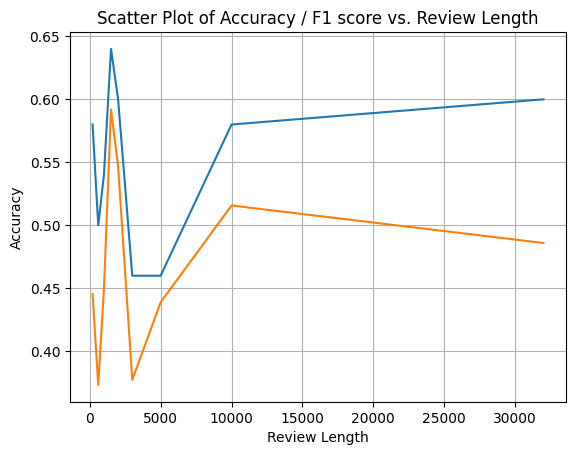

In [163]:
# plt.figure(figsize=(10, 6))
plt.plot(df_review_length['review_length'], df_review_length['accuracy'])
plt.plot(df_review_length['review_length'], df_review_length['f1_score'])
plt.title('Scatter Plot of Accuracy / F1 score vs. Review Length')
plt.xlabel('Review Length')
plt.ylabel('Accuracy')
plt.grid(True)
plt.show()

In [164]:
data

,review,label,small_extended,big_extended,small_float,big_float,small_float_binary,big_float_binary,small_few_shot,big_few_shot,random_binary,review_length_200_end,review_length_600_end,review_length_1000_end,review_length_1500_end,review_length_2000_end,review_length_3000_end,review_length_5000_end,review_length_10000_end
709,I first saw the film when it landed on US cabl...,0,1,1,-2,-2,-2,-2,0,1,0,1,1,1,0,1,1,1,1
19005,"Tom the cat, Jerry the mouse, and Spike the Do...",0,0,0,-2,-2,-2,-2,0,-2,0,0,1,1,0,1,1,1,1
21690,Average viewers looking for any sense of inter...,1,0,1,-2,-2,-2,-2,0,-2,1,1,1,1,1,1,1,0,1
10326,This movie made me so angry!! Here I am thinki...,1,0,1,-1,-2,1,-2,0,-2,1,1,1,1,1,1,1,1,1
12590,"After having seen Deliverance, movies like Pul...",0,0,1,-2,-2,-2,-2,0,1,0,1,1,1,1,1,1,1,0
5489,I managed to grab a viewing of this with the a...,1,0,1,-1,-2,1,-2,0,1,1,1,1,1,1,1,1,1,1
34228,"Engaging characters, nice animation, dynamite ...",0,0,1,-2,-2,-2,-2,0,1,1,1,1,1,0,1,1,0,1
22232,"I saw this in the early 70s (when I was 16), a...",0,1,1,-2,-2,-2,-2,0,1,1,1,1,1,0,1,1,1,0
32062,I'm not sure why there are no articles or post...,0,0,1,-2,-2,-2,-2,0,1,0,1,1,1,1,0,1,0,1
14017,Countless TV displays and the memorable appear...,0,0,1,-2,-2,-2,-2,0,1,1,1,1,1,1,1,1,1,1
